In [72]:
# Bib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install shap
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import zscore  # For Z-score calculation
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

In [73]:
# Load Data Function
def load_data():
    # load fra github
    url = "https://github.com/LinkLinucare/DataBusinessScience4/raw/main/kiva_loans.csv"
    return pd.read_csv(url)
# Her går vi ind og loader data, og fjerner outliers, loan amount over 50000
af = load_data()
af_usa = af[af['country'] == 'United States']
outlier_threshold = 50000
af_usa = af_usa[af_usa['loan_amount'] <= outlier_threshold]

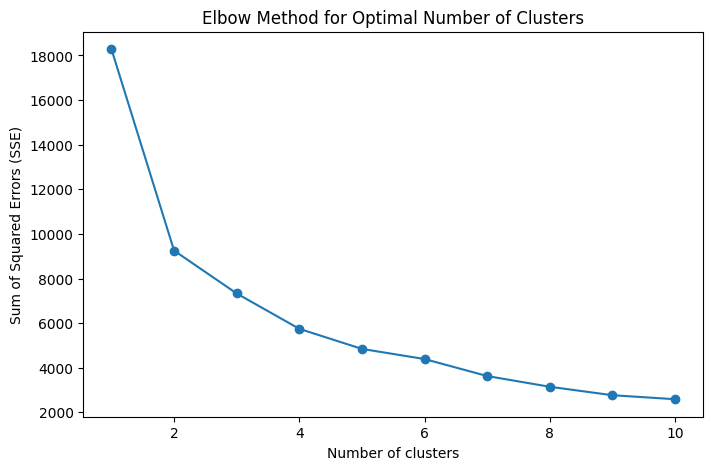

In [74]:
# Features
features = af_usa[['loan_amount', 'term_in_months', 'lender_count']]

# Label encode, da kmeans algoritmen kun arbejder med tal
le = LabelEncoder()
af_usa['sector_encoded'] = le.fit_transform(af_usa['sector'])

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Anvend PCA for at reducere til 2 dimensioner
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Elbow methodden
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show()

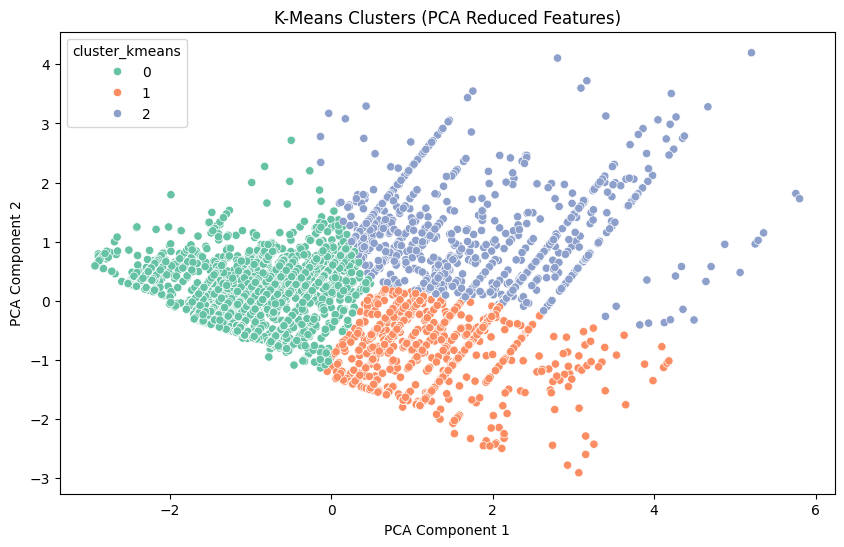

In [75]:
# K-means baseret på 3 clusters udfra overstående
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
af_usa['cluster_kmeans'] = kmeans.fit_predict(pca_features)

# Plot closters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=af_usa['cluster_kmeans'], palette='Set2')
plt.title("K-Means Clusters (PCA Reduced Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [76]:
# Sektorspecifik analyse
# Filtrer for sektor 1: 'Cosmetics Sales', 'Entertainment', 'Clothing'
sector1_filter = af_usa['sector'].isin(['Cosmetics Sales', 'Entertainment', 'Clothing'])
af_usa_sector1 = af_usa[sector1_filter]

# Filter for Sector 2: 'Services', 'Food Production/Sales', 'Restaurant'
sector2_filter = af_usa['sector'].isin(['Services', 'Food Production/Sales', 'Restaurant'])
af_usa_sector2 = af_usa[sector2_filter]



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


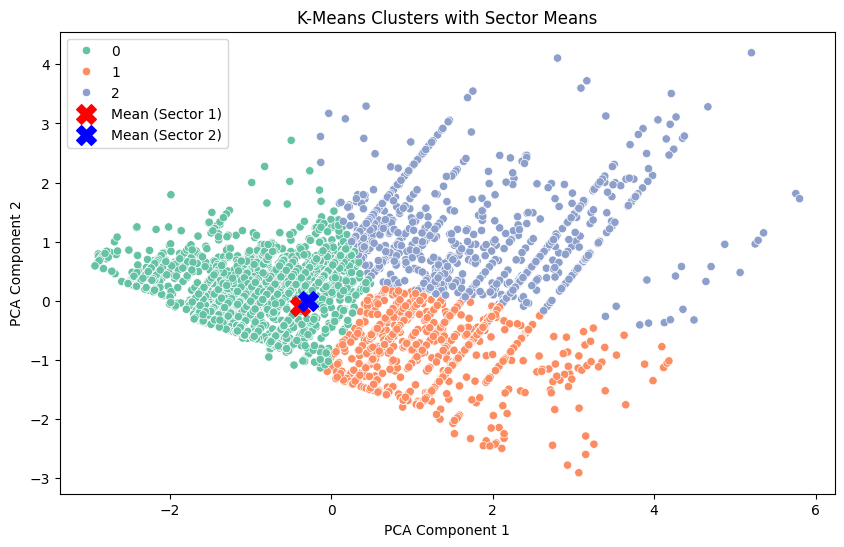

In [77]:
# Beregn gennemsnit for hver sektor og plot dem
sector1_means = af_usa_sector1[['loan_amount', 'term_in_months', 'lender_count']].mean()
sector1_means_scaled = scaler.transform([sector1_means])
sector1_means_pca = pca.transform(sector1_means_scaled)

sector2_means = af_usa_sector2[['loan_amount', 'term_in_months', 'lender_count']].mean()
sector2_means_scaled = scaler.transform([sector2_means])
sector2_means_pca = pca.transform(sector2_means_scaled)

# plot med gennemsnintspunkt
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=af_usa['cluster_kmeans'], palette='Set2')

# Tilføjer punktet
plt.scatter(sector1_means_pca[0, 0], sector1_means_pca[0, 1], color='red', s=200, label='Mean (Sector 1)', marker='X')
plt.scatter(sector2_means_pca[0, 0], sector2_means_pca[0, 1], color='blue', s=200, label='Mean (Sector 2)', marker='X')

plt.title("K-Means Clusters with Sector Means")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


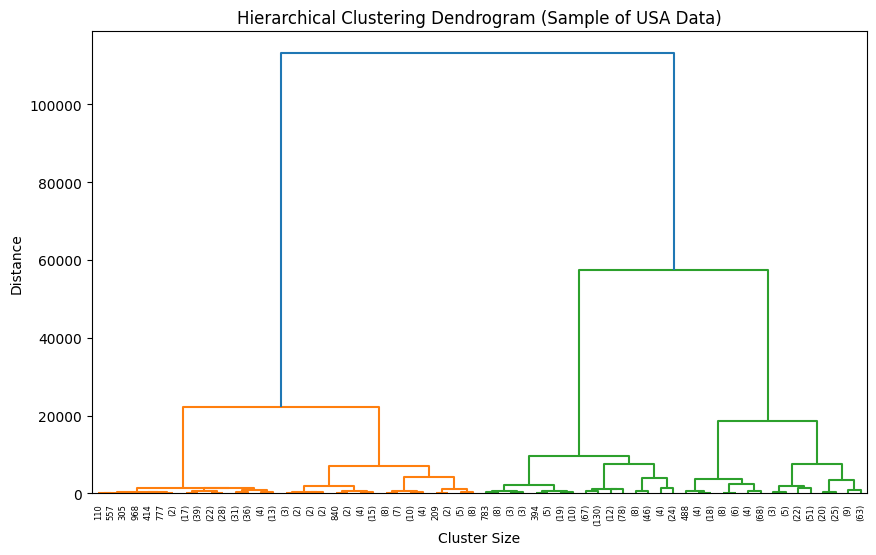

In [78]:
# Hierarchical Clustering
af_sample = af_usa.sample(n=1000, random_state=42)
Z = linkage(af_sample[['loan_amount', 'term_in_months', 'lender_count']], 'ward')

plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (Sample of USA Data)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (For nlp)
nltk.download('stopwords')

# Funktion til at forbehandle tekst
# Overordnet set gør vi det for at fjerne stopord og fjerne tal osv.
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)


af_usa['use_cleaned'] = af_usa['use'].fillna("").apply(preprocess_text)

# TF-IDF (Term Frequency-Inverse Document Frequency) for 'use' kolonnen (nøgleord)
# konvertere tekstdata i kolonnen 'use_cleaned' til numeriske værdier, hvor de 50 vigtigste nøgleord vægtes baseret på deres frekvens og betydning i datasættet, hvilket gør teksten egnet til maskinlæring.
vectorizer = TfidfVectorizer(max_features=50)  # Limit to 50 nøgleord
tfidf_matrix = vectorizer.fit_transform(af_usa['use_cleaned'])

# Opretter labels for høj/lav sandsynlighed (1 = høj sandsynlighed, 0 = lav sandsynlighed)
af_usa['high_chance'] = np.where(af_usa['lender_count'] >= af_usa['lender_count'].median(), 1, 0)

#  Bruger kun TF-IDF features (nøgleord)
X_supervised = pd.DataFrame(tfidf_matrix.toarray())
y_supervised = af_usa['high_chance']

# Træner en logistisk regressionsmodel
X_train, X_test, y_train, y_test = train_test_split(X_supervised, y_supervised, test_size=0.2, random_state=42)
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

# Funktion til at anbefale baseret på nøgleord
def recommend_chance_supervised(use_description):
    # Forbehandler input 'use_description'
    use_description_cleaned = preprocess_text(use_description)
    input_tfidf = vectorizer.transform([use_description_cleaned]).toarray()

    # Forudsiger sandsynligheden for succes
    predicted_chance = classifier.predict(input_tfidf)[0]
    chance_label = "High Chance" if predicted_chance == 1 else "Low Chance"

    return chance_label

# Eksemple
use_description_input = "purchase of equipment for business"
predicted_chance = recommend_chance_supervised(use_description_input) # Only pass the 'use_description' argument
print(f"Loan Chance Prediction (Supervised): {predicted_chance}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
